# Import libraries

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Import modules

In [2]:
# Add path for module
# FIXME: shouldn't need this with a package install (`__init__` should suffice?!)
MODEL_DIR = Path().resolve().parent / "PetersenEtAl2011"
sys.path.append(str(MODEL_DIR))

import run_displacement_model

# View the docstrings

In [3]:
help(run_displacement_model)

Help on module run_displacement_model:

NAME
    run_displacement_model

DESCRIPTION
    This file runs the PEA11 principal fault displacement model.
    - Any number of scenarios are allowed (e.g., user can enter multiple magnitudes).
    - The results are returned in a pandas DataFrame.
    - Only the principal fault displacement models for direct (i.e., not normalized) predictions are
    implemented herein currently.
    - Command-line use is supported; try `python run_displacement_model.py --help`
    - Module use is supported; try `from run_displacement_model import run_model`
    
    Reference: https://doi.org/10.1785/0120100035

FUNCTIONS
    main()
    
    run_model(*, magnitude: Union[float, int, List[Union[float, int]], numpy.ndarray], location: Union[float, int, List[Union[float, int]], numpy.ndarray], percentile: Union[float, int, List[Union[float, int]], numpy.ndarray], submodel: Union[str, List[str], numpy.ndarray] = 'elliptical', style: Union[str, List[str], numpy.nda

# Run displacement model

## Single scenarios

A single scenario is defined as a magnitude/location/percentile/style. Here is an example (note all parameters must be passed as keyword arguments).

In [4]:
mag, loc, perc = (
    6.8,
    0.25,
    0.5,
)

results = run_displacement_model.run_model(magnitude=mag, location=loc, percentile=perc)

results

,magnitude,location,style,percentile,model_name,mu,sigma,displ
0,6.8,0.25,strike-slip,0.5,elliptical,3.832595,1.1348,0.461822


This model should only be used for strike-slip faulting. That is the default style. A `UserWarning` will be issued and the user input will be over-ridden in the output table if another style is entered, such as `style="reverse"`:

In [5]:
results = run_displacement_model.run_model(
    magnitude=mag, location=loc, percentile=perc, style="reverse"
)

results

D:\Documents\_mydocs\Work FDHI\TEAM\Journal\kea23\PetersenEtAl2011\run_displacement_model.py:158: UserWarning: This model is only recommended for strike-slip faulting, but 'reverse' was entered.User input will be over-ridden.
  warnings.warn(


,magnitude,location,style,percentile,model_name,mu,sigma,displ
0,6.8,0.25,strike-slip,0.5,elliptical,3.832595,1.1348,0.461822


The Petersen et al. (2011) model provides three alternative submodels for different profile shapes. The default is the elliptical model, but the user can choose other options, such as `submodel="quadratic"`:

In [6]:
results = run_displacement_model.run_model(
    magnitude=mag, location=loc, percentile=perc, submodel="quadratic"
)

results

,magnitude,location,style,percentile,model_name,mu,sigma,displ
0,6.8,0.25,strike-slip,0.5,quadratic,3.980111,1.1346,0.53523


An error results if the wrong submodel is entered:

In [7]:
try:
    results = run_displacement_model.run_model(
        magnitude=mag, location=loc, percentile=perc, submodel="meow"
    )
except ValueError as e:
    print(e)

Invalid submodel names: ['meow']. Supported submodels are ['elliptical', 'quadratic', 'bilinear'].


In [8]:
del mag, loc, perc

## Multiple scenarios

Multiple magnitude/location/percentile/submodel scenarios can be run. All combinations of magnitudes, locations, percentiles, and submodels are run. Here is an example.

In [9]:
mags, locs, percs, shapes = (
    [6.8, 7.4],
    [0.25, 0.5],
    [0.5, 0.84],
    ["elliptical", "quadratic"],
)

results = run_displacement_model.run_model(
    magnitude=mags, location=locs, percentile=percs, submodel=shapes
)

results

,magnitude,location,style,percentile,model_name,mu,sigma,displ
0,6.8,0.25,strike-slip,0.50,elliptical,3.832595,1.1348,0.461822
1,6.8,0.25,strike-slip,0.50,quadratic,3.980111,1.1346,0.535230
2,6.8,0.25,strike-slip,0.84,elliptical,3.832595,1.1348,1.427515
3,6.8,0.25,strike-slip,0.84,quadratic,3.980111,1.1346,1.654093
4,6.8,0.50,strike-slip,0.50,elliptical,4.275260,1.1348,0.718988
5,6.8,0.50,strike-slip,0.50,quadratic,3.815205,1.1346,0.453861
6,6.8,0.50,strike-slip,0.84,elliptical,4.275260,1.1348,2.222429
7,6.8,0.50,strike-slip,0.84,quadratic,3.815205,1.1346,1.402627
8,7.4,0.25,strike-slip,0.50,elliptical,4.908215,1.1348,1.353975
9,7.4,0.25,strike-slip,0.50,quadratic,5.053811,1.1346,1.566182


# Calculate slip profile

There is a separate convenient function that does this, but here is a proof-of-concept. We can use `percentile=-1` to obtain the mean prediction, and then the area under the mean slip profile is equivalent to the *Average Displacement (AD)* that is implied by the model (for that magnitude).

In [10]:
mag = 7
locs = np.arange(0, 1.01, 0.01)
perc = -1

df = run_displacement_model.run_model(magnitude=mag, location=locs, percentile=perc)

df

,magnitude,location,style,percentile,model_name,mu,sigma,displ
0,7.0,0.00,strike-slip,-1.0,elliptical,1.329700,1.1348,0.071964
1,7.0,0.01,strike-slip,-1.0,elliptical,1.987208,1.1348,0.138889
2,7.0,0.02,strike-slip,-1.0,elliptical,2.254848,1.1348,0.181511
3,7.0,0.03,strike-slip,-1.0,elliptical,2.456974,1.1348,0.222170
4,7.0,0.04,strike-slip,-1.0,elliptical,2.624637,1.1348,0.262725
...,...,...,...,...,...,...,...,...
96,7.0,0.96,strike-slip,-1.0,elliptical,2.624637,1.1348,0.262725
97,7.0,0.97,strike-slip,-1.0,elliptical,2.456974,1.1348,0.222170
98,7.0,0.98,strike-slip,-1.0,elliptical,2.254848,1.1348,0.181511
99,7.0,0.99,strike-slip,-1.0,elliptical,1.987208,1.1348,0.138889


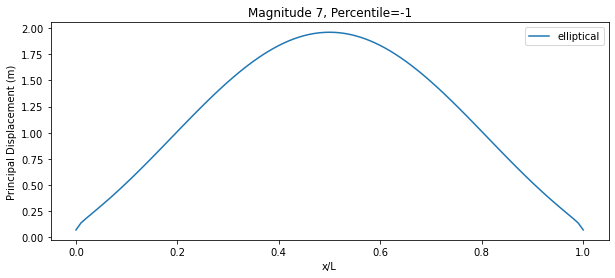

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
x, y = df["location"], df["displ"]
ax.plot(x, y, label=df["model_name"].iloc[0])
title = f"Magnitude {mag}, Percentile={perc}"
ax.set(xlabel="x/L", ylabel="Principal Displacement (m)", title=title)
ax.legend(loc="best");

In [12]:
print(max(y))
print(np.trapz(y, x))

1.9591590675596393
1.1830288874739983


## Compare slip profiles

#TODO: There is an error in the formulation for the bilinear model as presented in Eqns. 7/8/9 in Petersen et al. (2011). Because the sigma changes with $l/L'$, there is a huge step at $l/L'$ for any quantile that is not the median. Alex is coordinating with Rui on this ~ 12/1/2023

In [13]:
shapes = ["elliptical", "quadratic", "bilinear"]
df = run_displacement_model.run_model(magnitude=mag, location=locs, percentile=perc, submodel=shapes)

df

,magnitude,location,style,percentile,model_name,mu,sigma,displ
0,7.0,0.00,strike-slip,-1.0,elliptical,1.329700,1.1348,0.071964
1,7.0,0.00,strike-slip,-1.0,quadratic,1.981380,1.1346,0.138051
2,7.0,0.00,strike-slip,-1.0,bilinear,2.292800,1.2906,0.227741
3,7.0,0.01,strike-slip,-1.0,elliptical,1.987208,1.1348,0.138889
4,7.0,0.01,strike-slip,-1.0,quadratic,2.124059,1.1346,0.159222
...,...,...,...,...,...,...,...,...
298,7.0,0.99,strike-slip,-1.0,quadratic,2.124059,1.1346,0.159222
299,7.0,0.99,strike-slip,-1.0,bilinear,2.378006,1.2906,0.247997
300,7.0,1.00,strike-slip,-1.0,elliptical,1.329700,1.1348,0.071964
301,7.0,1.00,strike-slip,-1.0,quadratic,1.981380,1.1346,0.138051


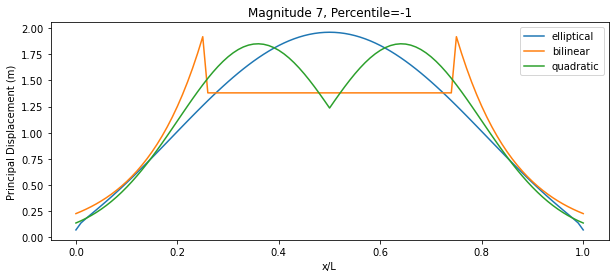

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for shape in ["elliptical", "bilinear", "quadratic"]:
    _df = df[df["model_name"] == shape]
    _df = _df.sort_values(by="location", ascending=True)
    x, y = _df["location"], _df["displ"]
    ax.plot(x, y, label=shape)

title = f"Magnitude {mag}, Percentile={perc}"
ax.set(xlabel="x/L", ylabel="Principal Displacement (m)", title=title)
ax.legend(loc="best");